# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install jupyter_contrib_nbextensions
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import seaborn as sns
import re

pd.set_option('max_columns', 500)

# For Plotting 
from itertools import cycle
plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 861.7/861.7 KB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.8/479.8 KB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for jupyter-latex-envs: filename=jupyter_latex_envs-1.4.6-py2.py3-none-any.whl size=963415 sha256=366b19434a254e332e94138c266548dcf56401743939828efaa4a6245c666331
  Stored in directory: /root/.cache/pip/wheels/a0/95/26/4cf34fb92765c95fb7851fd447511594bcc3a50e504bd09af9
  Created wheel for jupyter-nbextensions-configurator: filename=jupyter_nbextensions_configurator-0.4.1-py2.py3-none-any.whl size=465843 sha256=5313941d6d48dd8df5111680fbf0b2daf45bf3b0f3bb9b0ab7400ed6f987da2e
  Stored in directory: /root/.cache/pip/wheels/8d/c4/b5/e4b61f624036f83566580d61f24af7b73180b1361ee1ab3722
Successfully built jupyter-latex-envs jupyter-nbextensions-config

# load-in the dataset

In [2]:
tweets = pd.read_csv('../input/wordle-tweets/tweets.csv')

In [3]:
def process_tweets(tweets):
    tweets['tweet_datetime'] = pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date'] = tweets['tweet_datetime'].dt.date
    tweets['wordle_id'] = tweets['tweet_text'].str[:10]
    tweets['n_attempts'] = tweets['tweet_text'].str[11].astype('int')
    tweets['id'] = tweets['tweet_text'].str[7:10].astype('int')
    return tweets

tweets = process_tweets(tweets)

# how many tweets do we have for each date

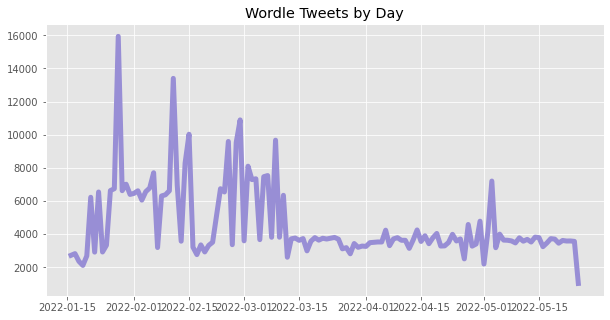

In [4]:
tweets['tweet_date'].value_counts() \
    .plot(figsize=(10, 5), title='Wordle Tweets by Day',
          color=color_pal[2], lw=5)
plt.show()

# Number of attempts analysis by wordle ID

In [5]:


tweets.groupby('wordle_id')['n_attempts'].value_counts() \
    .unstack() \
    .style.background_gradient(axis=1)



n_attempts,2,3,4,5,6
wordle_id,,,,,
Wordle 210,222,897,1064,489,165
Wordle 211,196,903,1016,564,215
Wordle 212,191,787,820,413,188
Wordle 213,51,260,630,697,481
Wordle 214,383,1012,823,363,122
Wordle 215,246,877,1017,579,224
Wordle 216,461,1952,2078,1199,415
Wordle 217,102,566,1031,843,418
Wordle 218,170,1009,1384,730,187


# how many attempts does it ususally take to solve?

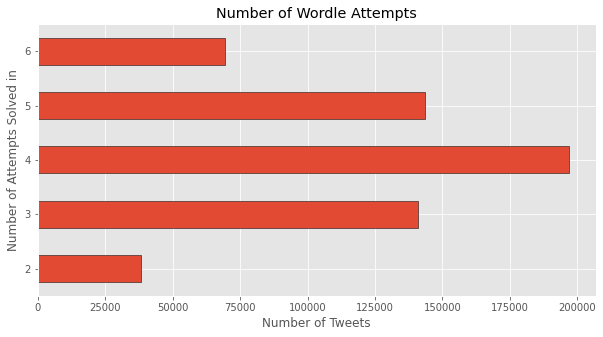

In [6]:
ax = tweets['n_attempts'].value_counts() \
    .sort_index() \
    .plot(figsize=(10, 5),
          kind='barh',
          title='Number of Wordle Attempts',
          edgecolor='black')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Attempts Solved in')
plt.show()

# fetch tweet text 

In [7]:
# Make dark squares consistent
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')

In [8]:
def parse_tweet_text(tweets):
    for n in range(6):
        n += 1
        tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1] \
            .str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)

        # Parse out the tweet text
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = \
                tweets['tweet_text'].str.split('\n').str[n + 1].str[:5]
        # Count number correct, misplaced, and incorrect
        tweets.loc[tweets[f'has_guess{n}'],
                       f'guess{n}_incorrect'] = tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_wrong_spot'] = tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_correct'] = tweets[f'guess{n}'].str.count('🟩')

        tweets.loc[tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n
    return tweets

tweets = parse_tweet_text(tweets)

In [9]:
# Keep additional tweet text
tweets['additional_text'] = \
    tweets.loc[~tweets['tweet_text'] \
    .str.split('\n').str[-1].str.contains('🟩')] \
    ['tweet_text'].str.split('\n').str[-1]

# Plot Results by attempt

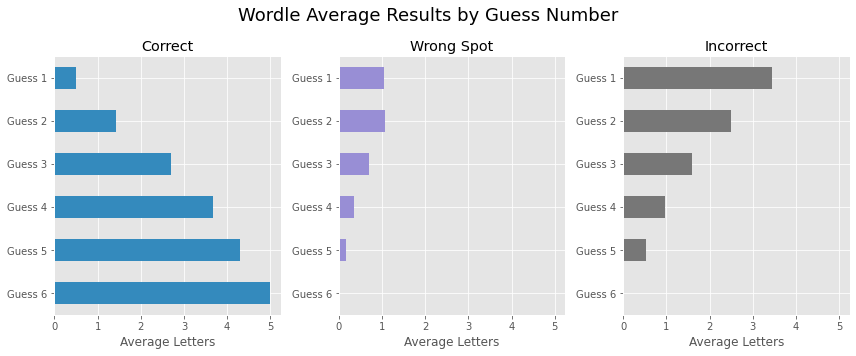

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False) \
        .plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=axs[i],
              color=color_pal[i+1])
    axs[i].set_xlabel('Average Letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()

# Letter analysis

In [11]:
answer_dict = {252 : 'SPILL',
     251 : 'VIVID',
     250 : 'BLOKE',
     249 : 'TROVE',
     248 : 'THORN',
     247 : 'OTHER',
     246 : 'TACIT',
     245 : 'SWILL',
     244 : 'DODGE',
     243 : 'SHAKE',
     242 : 'CAULK',
     241 : 'AROMA',
     240 : 'CYNIC',
     239 : 'ROBIN',
     238 : 'ULTRA',
     237 : 'ULCER',
     236 : 'PAUSE',
     235 : 'HUMOR',
     234 : 'FRAME',
     233 : 'ELDER',
     232 : 'SKILL',
     231 : 'ALOFT',
     230 : 'PLEAT',
     229 : 'SHARD',
     228 : 'MOIST',
     227 : 'THOSE',
     204 : 'GORGE',
     205 : 'QUERY',
     206 : 'DRINK',
     207 : 'FAVOR',
     208 : 'ABBEY',
     209 : 'TANGY',
     210 : 'PANIC',
     211 : 'SOLAR',
     212 : 'SHIRE',
     213 : 'PROXY',
     214 : 'POINT',
     215 : 'ROBOT',
     216 : 'PRICK',
     217 : 'WINCE',
     218 : 'CRIMP',
     219 : 'KNOLL',
     220 : 'SUGAR',
     221 : 'WHACK',
     222 : 'MOUNT',
     223 : 'PERKY',
     224 : 'COULD',
     225 : 'WRUNG',
     226 : 'LIGHT',
}

tweets['answer'] = tweets['id'].map(answer_dict)

In [12]:
first_guess_correct = []
for i, d in tweets.dropna(subset=['answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['answer']
    results =[x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

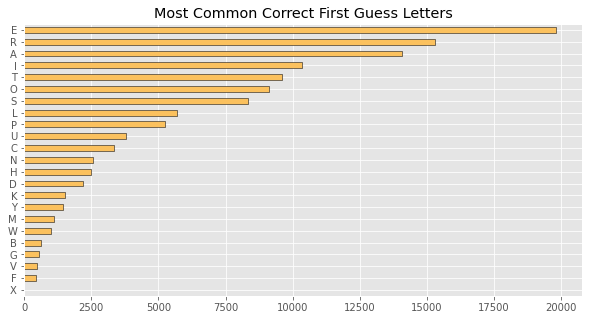

In [13]:
pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10, 5),
         title='Most Common Correct First Guess Letters',
         edgecolor='black', color=color_pal[4])
plt.show()